In [4]:
%pip install pandas
%pip install numpy
%pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from itertools import combinations



#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
df_titanic_train = pd.read_csv('titanic_training.csv')
df_titanic_test = pd.read_csv('titanic_test.csv')


print(df_titanic_train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [6]:
print(df_titanic_train.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [7]:
print(df_titanic_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [10]:
# Laden der Daten
df_titanic_train = pd.read_csv('titanic_training.csv')

# Extrahieren des Titels aus dem Namen
df_titanic_train['Title'] = df_titanic_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Mapping der Titel zu numerischen Werten
title_mapping = {
    "Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Dr": 4, "Rev": 5, "Col": 6,
    "Major": 7, "Mlle": 8, "Countess": 9, "Ms": 10, "Lady": 11, "Jonkheer": 12,
    "Don": 13, "Dona": 14, "Mme": 15, "Capt": 16, "Sir": 17
}
df_titanic_train['Title'] = df_titanic_train['Title'].map(title_mapping)

# Drop unnecessary columns and create X and y
X = df_titanic_train.drop(['Survived', 'Cabin', 'Ticket', 'Name'], axis=1)
y = df_titanic_train['Survived']

# Map categorical variables
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})
X['Embarked'] = X['Embarked'].map({'Q': 0, 'S': 1, 'C': 2})

# Entfernen von Zeilen mit fehlenden Werten
X.dropna(inplace=True)

# Ensure that the corresponding rows are removed from y
y = y[X.index]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste zur Speicherung der Ergebnisse
results = []

# Iterate over all possible feature combinations
for i in range(1, len(X_train.columns) + 1):
    for combination in combinations(X_train.columns, i):
        X_train_subset = X_train[list(combination)]
        X_val_subset = X_val[list(combination)]
        
        # Find the best n_neighbors for the current feature combination
        for n in range(1, 25):
            knn = KNeighborsClassifier(n_neighbors=n)
            knn.fit(X_train_subset, y_train)
            y_pred = knn.predict(X_val_subset)
            accuracy = accuracy_score(y_val, y_pred)
            
            #print(f"Kombination: {combination}, n_neighbors: {n}, Genauigkeit: {accuracy:.4f}")
            
            # Speicherung der aktuellen Kombination und der Genauigkeit
            results.append((combination, n, accuracy))

# Sortieren der Ergebnisse nach Genauigkeit
results.sort(key=lambda x: x[2], reverse=True)

# Ausgabe der 5 besten Kombinationen
print("Die 5 besten Kombinationen:")
for i in range(5):
    print(f"Kombination: {results[i][0]}, n_neighbors: {results[i][1]}, Genauigkeit: {results[i][2]:.4f}")

# Ausgabe der 5 schlechtesten Kombinationen
print("\nDie 5 schlechtesten Kombinationen:")
for i in range(1, 6):
    print(f"Kombination: {results[-i][0]}, n_neighbors: {results[-i][1]}, Genauigkeit: {results[-i][2]:.4f}")



Die 5 besten Kombinationen:
Kombination: ('Pclass', 'Sex', 'Parch', 'Embarked'), n_neighbors: 5, Genauigkeit: 0.8042
Kombination: ('Pclass', 'SibSp', 'Title'), n_neighbors: 3, Genauigkeit: 0.7972
Kombination: ('Pclass', 'Sex', 'SibSp', 'Title'), n_neighbors: 3, Genauigkeit: 0.7972
Kombination: ('Pclass', 'Sex', 'Parch', 'Embarked'), n_neighbors: 22, Genauigkeit: 0.7972
Kombination: ('Pclass', 'Sex', 'Parch', 'Embarked'), n_neighbors: 23, Genauigkeit: 0.7972

Die 5 schlechtesten Kombinationen:
Kombination: ('Parch', 'Embarked'), n_neighbors: 4, Genauigkeit: 0.3706
Kombination: ('Parch', 'Embarked'), n_neighbors: 13, Genauigkeit: 0.3916
Kombination: ('Embarked',), n_neighbors: 8, Genauigkeit: 0.3986
Kombination: ('Embarked',), n_neighbors: 7, Genauigkeit: 0.3986
Kombination: ('Embarked',), n_neighbors: 6, Genauigkeit: 0.3986


In [16]:
df_titanic_train = pd.read_csv('titanic_training.csv')



# Drop unnecessary columns and create X and y
X = df_titanic_train.drop(['Survived', 'Cabin', 'Ticket', 'Name'], axis=1)
y = df_titanic_train['Survived']

# Map categorical variables
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})
X['Embarked'] = X['Embarked'].map({'Q': 0, 'S': 1, 'C': 2})

# Entfernen von Zeilen mit fehlenden Werten
X.dropna(inplace=True)

# Ensure that the corresponding rows are removed from y
y = y[X.index]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Festes Modell basierend auf der besten Kombination
best_features = ['Pclass', 'Sex', 'Parch', 'Embarked']
n_neighbors = 5

# Modelltraining
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train[best_features], y_train)

# Vorhersage und Genauigkeit
y_pred = knn.predict(X_val[best_features])
accuracy = accuracy_score(y_val, y_pred)

print(f"Genauigkeit des Modells mit den besten Features: {accuracy:.4f}")


Genauigkeit des Modells mit den besten Features: 0.8042


Fragen an Hörchenberger:
Umfang Dokumentation, --> Keine Regelung, Vollständig alles erfassen was gemacht wurde --> Ideen Gedankengänge,
Inhalt Dokumentation,
Fehlende Daten bei Age Cabine ausfüllen oder nicht --> nicht ausfüllen


Dokumentieren dass Datensatz den Gesamtdatensatz besätigt und die Struktur bestätigt,
Grafik machen
Alter erklären, Kabine erklären
erklären dass bei gewissen punkten daten fehlen --> Alter Kritisch für ML Modell

IDEE kleine Abfrage von Daten zum ermitteln ob überlebt oder nicht



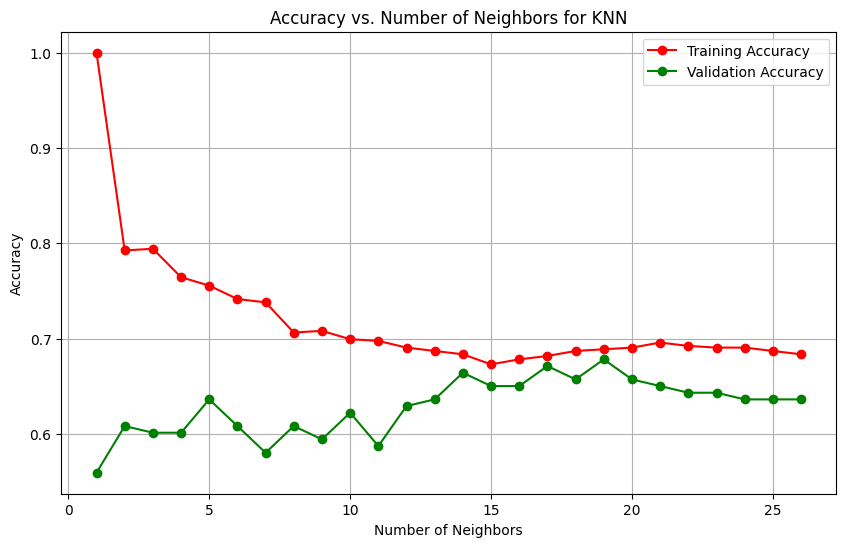

In [9]:
# Define the range of neighbors to test
neighbors_range = range(1, 27)
train_scores = []
valid_scores = []

# Train and validate for each number of neighbors
for n_neighbors in neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_train_pred = knn.predict(X_train)
    y_val_pred = knn.predict(X_val)
    train_scores.append(accuracy_score(y_train, y_train_pred))
    valid_scores.append(accuracy_score(y_val, y_val_pred))

# Plot accuracy vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_range, train_scores, 'o-', color='r', label='Training Accuracy')
plt.plot(neighbors_range, valid_scores, 'o-', color='g', label='Validation Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors for KNN')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
#Hyperparameter Tuning

# Define the kNN model
knn = KNeighborsClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27],   # Number of neighbors to use
    'weights': ['uniform', 'distance'], # Weight function used in prediction
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and best score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)
# Use the best estimator from the grid search
best_knn = grid_search.best_estimator_

# Make predictions on the validation set
y_pred = best_knn.predict(X_val)

# Calculate and print the accuracy on the validation set
accuracy = accuracy_score(y_val, y_pred)
print("Validation Set Accuracy:", accuracy)


Fitting 5 folds for each of 78 candidates, totalling 390 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.6714019562179786
Validation Set Accuracy: 0.6503496503496503


Weitere Methoden:
    -Random Decision Forest (Rauschtolleranz, Gewichtung von Spalten / fehlende Werte)
    -Support Vector Machine (gut bei hochdimensionalen Datensätzen)
    -Neuronales Netzwerk zum zeigen nicht mit Kanonen auf Spatzen schießen